**Hardware Specifications:**
-  Memory: 15.4 GiB
-  Processor: Intel® Core™ i7-8550U CPU @ 1.80GHz × 8 
-  OS-type: Ubuntu 18.10 - 64-bit

**Model execution time:**
-  Random Forest: CPU times: user 2min 4s, sys: 304 ms, total: 2min 5s
-  Logistic regression: CPU times: user 2min 17s, sys: 11.3 s, total: 2min 28s
    

**Objective:**Predict the  default status of farmers, by following the steps listed  down in the contents section

## Content

1.  Import Libraries
2.  Load Dataset
3.  Data quality and outlier detection
4.  Feature Engineering
5.  Feature Selection
6.  Modelling
    -  Logistic Regression
    -  Random Forest

## 1. Import Libraries

In [1]:
import pandas as pd
import numpy as np
import scipy as sp
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import itertools
import pymssql
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

## 2. Load Dataset from Database

In [4]:
conn = pymssql.connect(server='ndizi.oneacrefund.org', 
                       database = 'OAF_DATA_SCIENCE',
                       user='DSUser1',
                       password='Ext3rn@l', 
                       port=1433) 

In [44]:
train = "SELECT * FROM ds_screening_training_set"

# Excute Query here
df = pd.read_sql(train,conn)

df.head(5)

,SeasonName,DistrictName,SiteName,GroupName,ClientID,TotalOfSolarBundles,TotalRepayment,TotalCredit,NumRepayments,FirstRepaymentDate,Facilitator,LandSize,NewMember,TotalEnrolledSeasons,RepaymentDate,RepaymentTypeName,RepaymentCategoryName,RunningTotal,default_status
0,LR2016,Butere,Malaha,Fanya Ule,895315,0,10220.0,10220.0,9,2015-11-13,False,0.5,True,1,20151120,MobileMoney,Revenue,1025.0,True
1,LR2016,Webuye,Sinoko,Alpha,385693,2,19890.0,19890.0,13,2015-11-10,False,0.5,False,7,20151110,MobileMoney,Revenue,500.0,True
2,LR2015,Lugari,Mulimani,Baraka,1635357,1,13220.0,13220.0,12,2014-11-10,True,0.75,False,6,20141208,MobileMoney,Revenue,9020.0,True
3,LR2016,Webuye,Ondoti,Timakila,568321,1,9700.0,9700.0,7,2015-11-16,False,0.5,True,4,20151116,MobileMoney,Revenue,500.0,True
4,LR2018,Bungoma,Khaoya,Baraka,38603,0,6085.0,6085.0,8,2017-11-07,False,0.5,False,6,20171130,MobileMoney,Revenue,504.0,True


### Note: Insert the holdout set here as csv

In [2]:
#df.to_csv('1AFcsv')
df= pd.read_csv('1AFcsv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 636464 entries, 0 to 636463
Data columns (total 20 columns):
Unnamed: 0               636464 non-null int64
SeasonName               636464 non-null object
DistrictName             636464 non-null object
SiteName                 636464 non-null object
GroupName                636464 non-null object
ClientID                 636464 non-null int64
TotalOfSolarBundles      636464 non-null int64
TotalRepayment           636464 non-null float64
TotalCredit              636464 non-null float64
NumRepayments            636464 non-null int64
FirstRepaymentDate       636464 non-null object
Facilitator              636464 non-null bool
LandSize                 636464 non-null float64
NewMember                636464 non-null bool
TotalEnrolledSeasons     636464 non-null int64
RepaymentDate            636464 non-null int64
RepaymentTypeName        636464 non-null object
RepaymentCategoryName    636464 non-null object
RunningTotal             636464 

In [4]:
df['ClientID'].nunique()

441371

## 3. Data Quality and Outlier Detection

#### Check for missing or possibly erroneous data.

In [5]:
#There are no duplicated rows (this takes a while to run):
len(df[df.duplicated() == True])

0

In [34]:
#Show total null values per column
df.isnull().sum()

Unnamed: 0               0
SeasonName               0
DistrictName             0
SiteName                 0
GroupName                0
ClientID                 0
TotalOfSolarBundles      0
TotalRepayment           0
TotalCredit              0
NumRepayments            0
FirstRepaymentDate       0
Facilitator              0
LandSize                 0
NewMember                0
TotalEnrolledSeasons     0
RepaymentDate            0
RepaymentTypeName        0
RepaymentCategoryName    0
RunningTotal             0
default_status           0
dtype: int64

### Outlier detection

##### Z-statistic/score

The best way to detect outliers is to measure how far off they are from the mean in terms of the standard deviation, we can use the z score to calculate this. The z-score is given by:
\begin{gather*}
z=\ \dfrac{x\ -\ \mu }{\sigma }\\
\\
\mu \ =\ mean\\
\sigma \ =standard\ deviation\\
\end{gather*}


 

In [35]:
#Create z-standardized values

for col in ['TotalRepayment', 
            'TotalCredit']:
    df[col] = df[col].astype('float64')

df['payment_z'] = np.abs(stats.zscore(df['TotalRepayment'])) #create and absolute value z-statistic
df['credit_z'] = np.abs(stats.zscore(df['TotalCredit'])) 

In [36]:
outliers= (df['payment_z']>3).sum()
inliers = (df['credit_z']<=3).sum()
percentage = (outliers/(outliers+inliers))*100
print('Our data contains %d outliers' %outliers)
print('Our data contains %d inliers that are not extreme values' %inliers)
print('Approximately %d percent of the sample contains outliers' %percentage)

Our data contains 9643 outliers
Our data contains 626607 inliers that are not extreme values
Approximately 1 percent of the sample contains outliers


Although only one percent of the data is more that 3 standard deviations away from the data. 
There is no way to verify that the extreme values are indeed outliers, therefore I won't drop the potential 
outliers and would rather ensure that the selected model is robust to outliers

## 4. Feature Engineering

#### Change data type for datasets

In [37]:
#Classify columns as dates

df['FirstRepaymentDate'] = pd.to_datetime(df['FirstRepaymentDate'])

In [38]:
df['RepaymentDate'] = pd.to_datetime(df['RepaymentDate'])

#### Extracting month and year when the first and last repayment was made

In [40]:
df['first_repayment_month'] = df['FirstRepaymentDate'].dt.month #month
df['first_repayment_year'] = df['FirstRepaymentDate'].dt.year #year
df['last_repayment_month'] = df['RepaymentDate'].dt.month #month
df['last_repayment_year'] = df['RepaymentDate'].dt.year #year

In [41]:
import calendar
df['first_repayment_month'] = df['first_repayment_month'].apply(lambda x: calendar.month_abbr[x])
df['last_repayment_month'] = df['last_repayment_month'].apply(lambda x: calendar.month_abbr[x])

#### Introduce categorical variables as dummy variables and exclude the first category to avoid the dummy trap

In [42]:
categorical_vars = ['SeasonName', 'DistrictName', 'RepaymentTypeName', 'first_repayment_month', 
                    'first_repayment_year', 'default_status', 'RepaymentCategoryName',  
                    'last_repayment_month', 'last_repayment_year', 'NewMember','Facilitator', 'SiteName', 
                    'GroupName']

#print(df['SeasonName'].nunique())   
print(df['RepaymentTypeName'].nunique())
print(df['RepaymentCategoryName'].nunique())
print(df['DistrictName'].nunique())
print(df['SiteName'].nunique())
print(df['GroupName'].nunique())


df = pd.get_dummies(df,columns=categorical_vars[:8],drop_first=True)

7
5
39
1539
23925


## 5. Feature Selection

Feature selection with Dummy Variables: In this instance we exclude the first dummy variable in order to avoid the dummy trap

In [43]:
feature_cols = ['TotalOfSolarBundles','TotalRepayment','TotalCredit',
                'NumRepayments','Facilitator', 'LandSize', 'NewMember','TotalEnrolledSeasons',
                'RunningTotal', 'NewMember', 'Facilitator', 'RepaymentTypeName_Trial', 
                'SeasonName_LR2016', 'SeasonName_LR2017','SeasonName_LR2018','DistrictName_Belgut', 
                'DistrictName_Borabu', 'DistrictName_Bungoma', 'DistrictName_Busia', 'DistrictName_Butere',
                'DistrictName_Cherangany', 'DistrictName_Chwele','DistrictName_Gem', 'DistrictName_Green Shamba', 
                'DistrictName_Gucha', 'DistrictName_Hamisi', 'DistrictName_KENYA STAFF','DistrictName_Kabiyet',
                'DistrictName_Kabondo', 'DistrictName_Kakamega (South)', 'DistrictName_Kakamega B (North)',
                'DistrictName_Kapsabet', 'DistrictName_Kimilili','DistrictName_Kisii', 'DistrictName_Lugari',  
                'DistrictName_Matete', 'DistrictName_Migori', 'DistrictName_Mumias', 'DistrictName_Nambale',
                'DistrictName_Ndalu', 'DistrictName_Nyamira', 'DistrictName_Rachuonyo','DistrictName_Rongo',
                'DistrictName_Saboti', 'DistrictName_Sagana', 'DistrictName_Serabo', 'DistrictName_Sirisia',
                'DistrictName_Suneka', 'DistrictName_Teso', 'DistrictName_Tinderet', 'DistrictName_Vihiga',
                'DistrictName_Webuye', 'RepaymentTypeName_Crop Failure Compensation', 'DistrictName_Masaba',
                'RepaymentTypeName_Deceased Debt Cancellation', 'RepaymentTypeName_Dropped Client Refund',
                'RepaymentTypeName_MobileMoney','RepaymentTypeName_Receipt', 'first_repayment_month_Aug',
                'first_repayment_month_Dec', 'first_repayment_month_Feb', 'first_repayment_month_Jan',
                'first_repayment_month_Jul', 'first_repayment_month_Jun', 'first_repayment_month_Mar', 
                'first_repayment_month_May', 'first_repayment_month_Nov', 'first_repayment_month_Oct',
                'first_repayment_month_Sep', 'first_repayment_year_2015', 'first_repayment_year_2016',
                'first_repayment_year_2017', 'RepaymentCategoryName_Refund', 
                'RepaymentCategoryName_Revenue', 'RepaymentCategoryName_Trial', 'RepaymentCategoryName_Write Off']
                

In [44]:
X = df[feature_cols]
y = df['default_status_True']

### We only want the best 40 features in the model

In [45]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.preprocessing import MinMaxScaler
X_norm = MinMaxScaler().fit_transform(X)
chi_selector = SelectKBest(chi2, k=40)
chi_selector.fit(X_norm, y)

SelectKBest(k=40, score_func=<function chi2 at 0x7f378b079730>)

In [46]:
chi_support = chi_selector.get_support()
chi_feature = X.loc[:,chi_support].columns.tolist()
print(str(len(chi_feature)), 'selected features')

40 selected features


In [47]:
X_2 = df[chi_feature]

### Feature importance in determining default Status

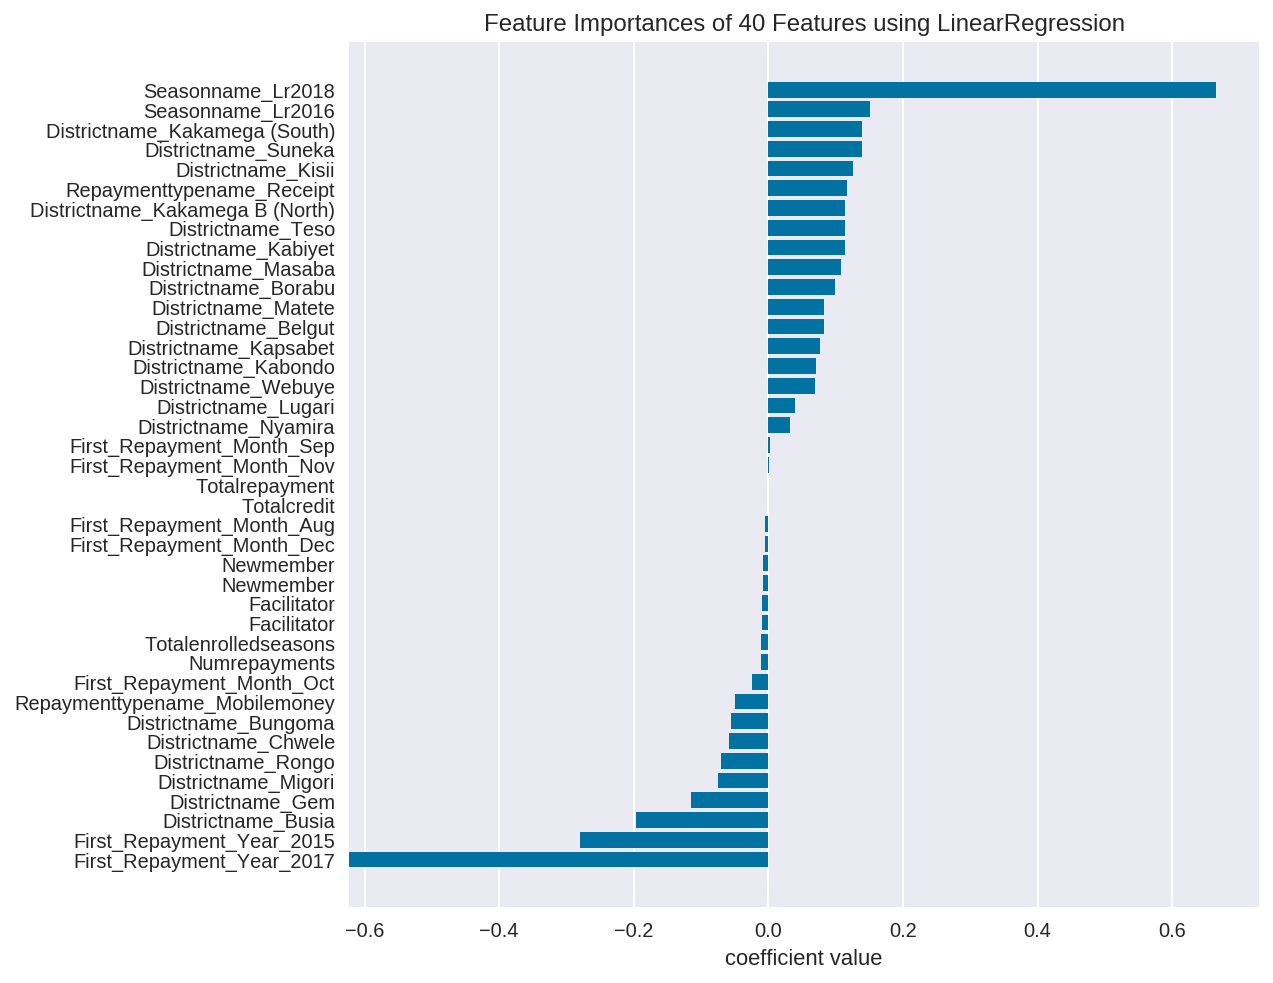

In [102]:
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression 

from yellowbrick.features.importances import FeatureImportances

#Setting the style
plt.style.use('seaborn-darkgrid')


#Size of the figure
plt.rcParams["figure.figsize"]=9,7 #(width, height)

# Create a new figure
fig = plt.figure()
ax = fig.add_subplot()

# Title case the feature for better display and create the visualizer
labels = list(map(lambda s: s.title(), X_2))
viz = FeatureImportances(LinearRegression(), ax=ax, labels=labels, relative=False)

# Fit and show the feature importances
viz.fit(X_2, y)
viz.poof()

## 6. Modelling

### Visualization: Confusion matrices and AUC curves

In [48]:
import itertools
from sklearn.metrics import roc_curve, auc, roc_auc_score, log_loss, accuracy_score, confusion_matrix

def plot_cm(ax, y_true, y_pred, classes, title, th=0.5, cmap=plt.cm.Blues):
    y_pred_labels = (y_pred>th).astype(int)
    
    cm = confusion_matrix(y_true, y_pred_labels)
    
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.set_title(title)

    tick_marks = np.arange(len(classes))
    ax.set_xticks(tick_marks)
    ax.set_yticks(tick_marks)
    ax.set_xticklabels(classes)
    ax.set_yticklabels(classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        ax.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    ax.set_ylabel('True label')
    ax.set_xlabel('Predicted label')

def plot_auc(ax, y_train, y_train_pred, y_test, y_test_pred, th=0.5):

    y_train_pred_labels = (y_train_pred>th).astype(int)
    y_test_pred_labels  = (y_test_pred>th).astype(int)

    fpr_train, tpr_train, _ = roc_curve(y_train,y_train_pred)
    roc_auc_train = auc(fpr_train, tpr_train)
    acc_train = accuracy_score(y_train, y_train_pred_labels)

    fpr_test, tpr_test, _ = roc_curve(y_test,y_test_pred)
    roc_auc_test = auc(fpr_test, tpr_test)
    acc_test = accuracy_score(y_test, y_test_pred_labels)

    ax.plot(fpr_train, tpr_train)
    ax.plot(fpr_test, tpr_test)

    ax.plot([0, 1], [0, 1], 'k--')

    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('ROC curve')
    
    train_text = 'train acc = {:.3f}, auc = {:.2f}'.format(acc_train, roc_auc_train)
    test_text = 'test acc = {:.3f}, auc = {:.2f}'.format(acc_test, roc_auc_test)
    ax.legend([train_text, test_text])

### Logistic Regression Model (Baseline mode)

In [49]:
from sklearn.model_selection import train_test_split 

X_train, X_test, y_train, y_test = train_test_split(X_2,y,test_size=0.25)

In [57]:
%%time
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score 

log_model = LogisticRegression()

log_model.fit(X_train,y_train)
print(log_model.score(X_test,y_test))

y_pred = log_model.predict(X_test)

cross_val_score(log_model,X,y,cv=10).mean()


0.6570552301465598
CPU times: user 2min 17s, sys: 11.3 s, total: 2min 28s
Wall time: 2min 18s


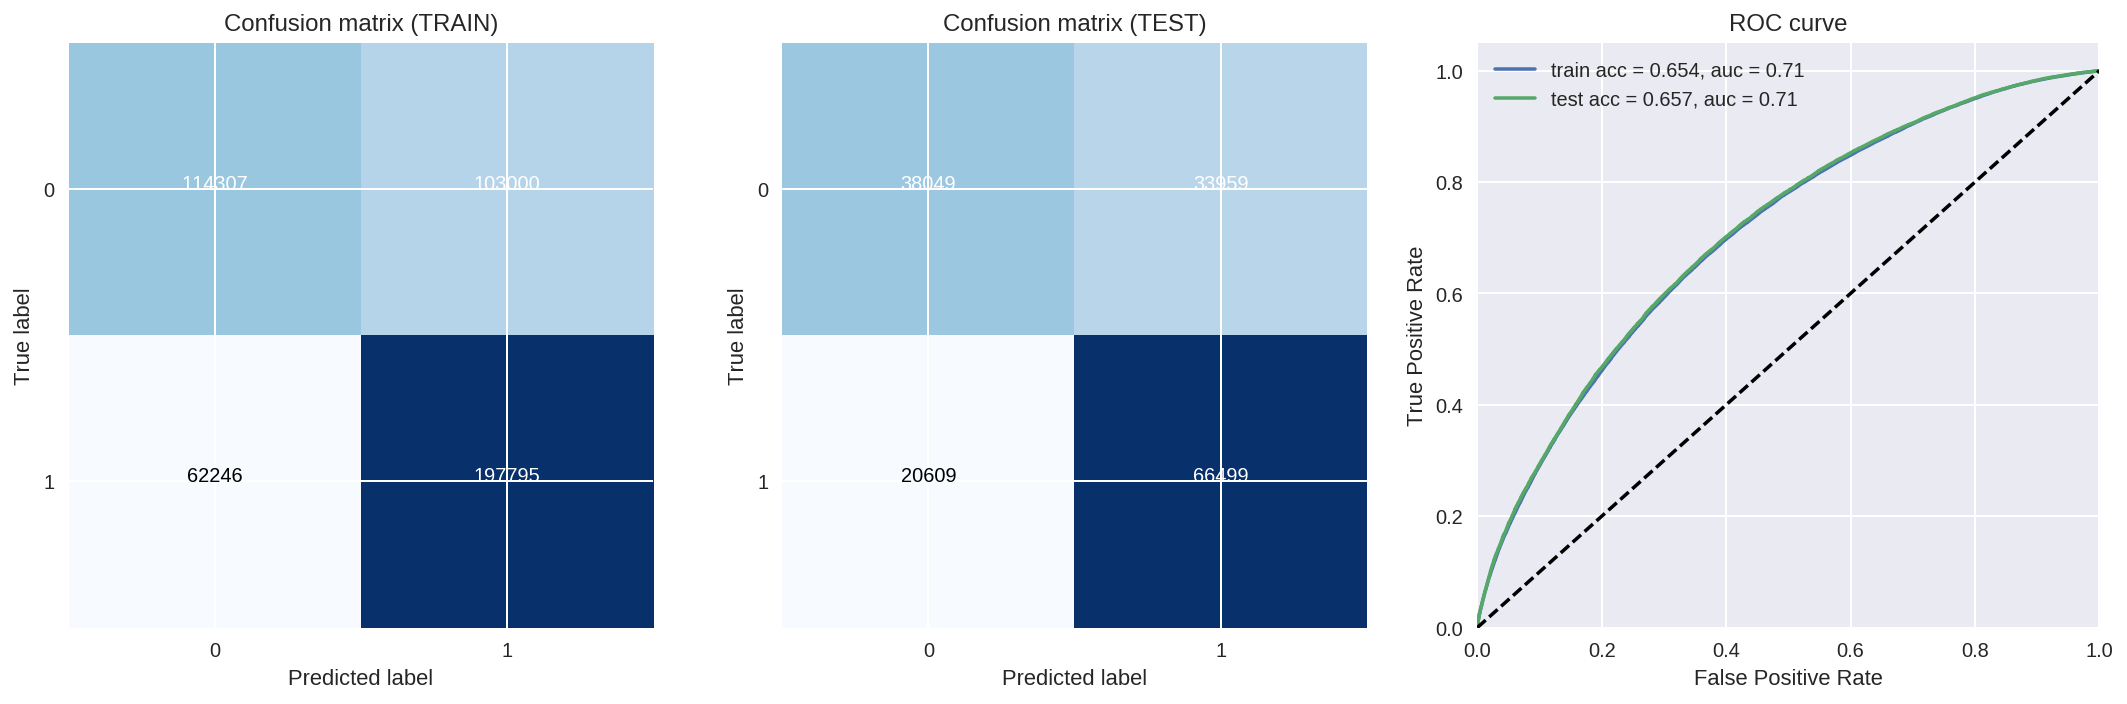

In [53]:
y_train_pred = log_model.predict_proba(X_train)[:,1]
y_test_pred = log_model.predict_proba(X_test)[:,1]

threshold = 0.5

fig,ax = plt.subplots(1,3)
fig.set_size_inches(15,5)

plot_cm(ax[0],  y_train, y_train_pred, [0,1], 'Confusion matrix (TRAIN)', threshold)
plot_cm(ax[1],  y_test, y_test_pred,   [0,1], 'Confusion matrix (TEST)', threshold)
plot_auc(ax[2], y_train, y_train_pred, y_test, y_test_pred, threshold)
    
plt.tight_layout()
plt.show()

## Random Forest Model

In [56]:
%%time
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=100, min_samples_leaf=5)
rf.fit(X_train,y_train)

CPU times: user 2min 4s, sys: 304 ms, total: 2min 5s
Wall time: 2min 5s


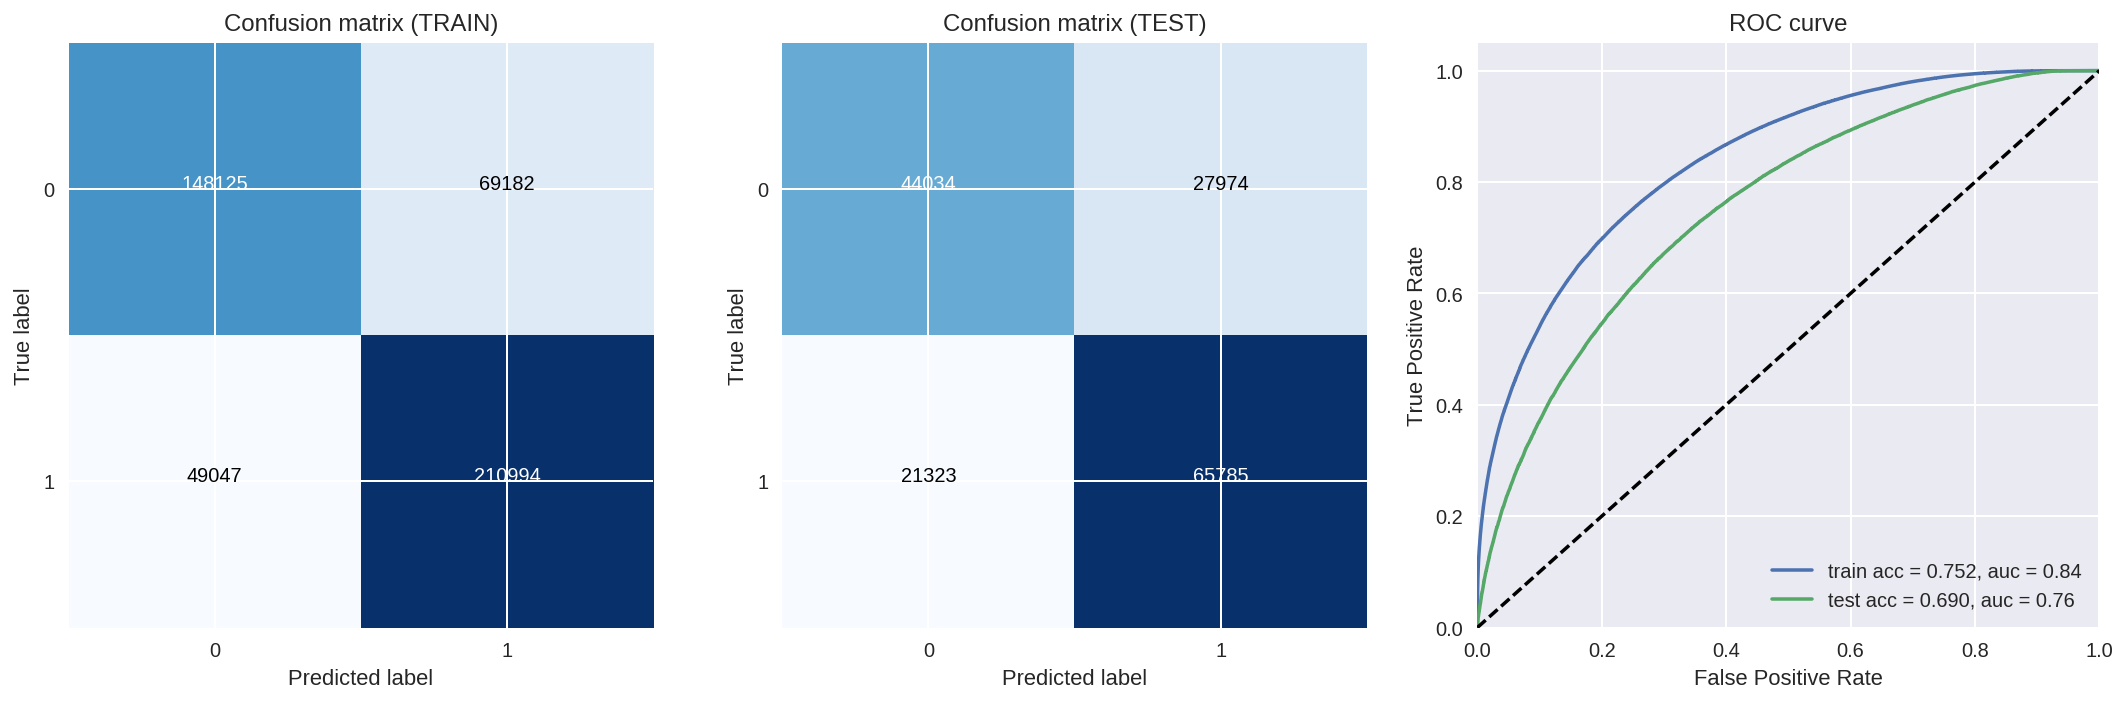

In [55]:

from sklearn.metrics import roc_curve, auc, roc_auc_score, log_loss, accuracy_score

threshold = 0.5
y_train_pred = rf.predict_proba(X_train)[:,1]
y_test_pred = rf.predict_proba(X_test)[:,1]

fig,ax = plt.subplots(1,3)
fig.set_size_inches(15,5)

plot_cm(ax[0],  y_train, y_train_pred, [0,1], 'Confusion matrix (TRAIN)', threshold)
plot_cm(ax[1],  y_test, y_test_pred,   [0,1], 'Confusion matrix (TEST)', threshold)
plot_auc(ax[2], y_train, y_train_pred, y_test, y_test_pred, threshold)
    
plt.tight_layout()
plt.show()

## Predictions Analysis

In [95]:
y_predict= pd.DataFrame(y_train_pred, columns=['y_predict'])

In [96]:
y_predict['count_defaulters']= np.where((y_train_pred>=0.5), "defaulter", 'good_creditor')

In [98]:
target_count=y_predict['count_defaulters'].value_counts()


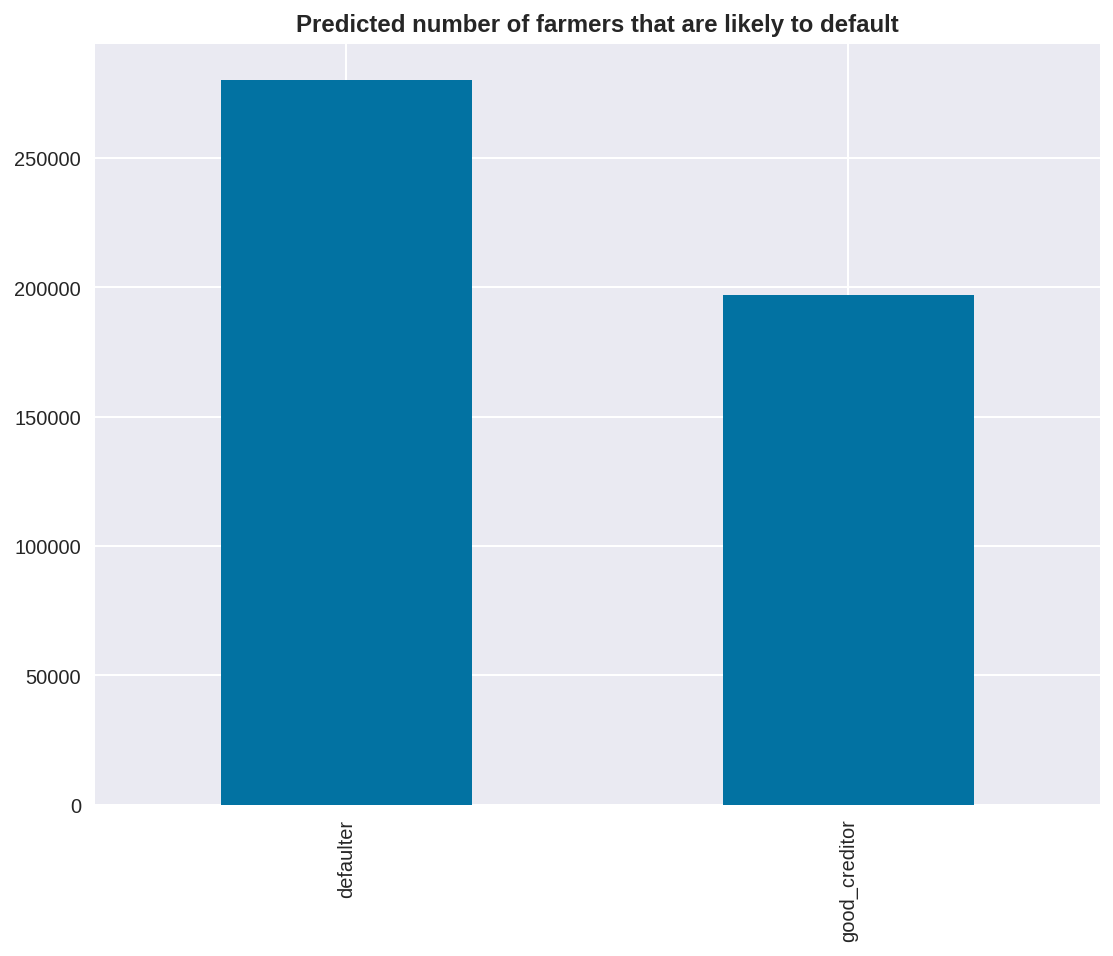

In [101]:
#Setting the style
plt.style.use('seaborn-darkgrid')


#Size of the figure
plt.rcParams["figure.figsize"]=9,7 #(width, height)

target_count.plot(kind='bar', title='Count (target)')
plt.title('Predicted number of farmers that are likely to default', fontweight='bold')

plt.show()

In [103]:
y_predict.to_csv('predictions.csv')

## Model Evalution

- **Confusion Matrix:**
The random forest outperforms the baseline logistic regression model, given that the model is able to
accurately predict more observations correctly than the baseline logistic model for the training dataset

- **ROC curve:** 
 -  The ROC curve is created by plotting the true positive rate against the false positive rate at various threshold settings. The Area Under Curve(AUC) is used for binary classification problem. AUC of a classifier is equal to the probability that the classifier will rank a randomly chosen positive example higher than a randomly chosen negative example. 
 -  The AUC for the logistic regression is lower than that of the random forest classifier and hence, the random forest performs better on this dataset than the logistic regression.

**Conclusion:** Farmers that farmed in the growing season 2016 and 2018 are more likely to default on their loan